# Data Cleaning and Manipulation

In [1]:
import pandas as pd
import datetime as dt
import fasttext
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [148]:
# read csv files
biden_df = pd.read_csv(r"C:\Users\User\iCloudDrive\Cursos\Data Circle\DataCircle_Twitter_Project\hashtag_joebiden.csv",lineterminator='\n')
trump_df = pd.read_csv(r"C:\Users\User\iCloudDrive\Cursos\Data Circle\DataCircle_Twitter_Project\hashtag_donaldtrump.csv", lineterminator='\n')

print(biden_df.info())
print(trump_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776886 entries, 0 to 776885
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   created_at            776886 non-null  object 
 1   tweet_id              776886 non-null  float64
 2   tweet                 776886 non-null  object 
 3   likes                 776886 non-null  float64
 4   retweet_count         776886 non-null  float64
 5   source                776173 non-null  object 
 6   user_id               776886 non-null  float64
 7   user_name             776861 non-null  object 
 8   user_screen_name      776886 non-null  object 
 9   user_description      694877 non-null  object 
 10  user_join_date        776886 non-null  object 
 11  user_followers_count  776886 non-null  float64
 12  user_location         543092 non-null  object 
 13  lat                   355293 non-null  float64
 14  long                  355293 non-null  float64
 15  

## Data Preprocessing

In [149]:
# create a new column 'candidate' to differentiate tweets of each candidate after concatenation 
trump_df['candidate'] = 'trump'

# biden dataframe 
biden_df['candidate'] = 'biden'

# combining the dataframes 
twitter_df = pd.concat([trump_df, biden_df])


In [150]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1747805 entries, 0 to 776885
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   created_at            object 
 1   tweet_id              float64
 2   tweet                 object 
 3   likes                 float64
 4   retweet_count         float64
 5   source                object 
 6   user_id               float64
 7   user_name             object 
 8   user_screen_name      object 
 9   user_description      object 
 10  user_join_date        object 
 11  user_followers_count  float64
 12  user_location         object 
 13  lat                   float64
 14  long                  float64
 15  city                  object 
 16  country               object 
 17  continent             object 
 18  state                 object 
 19  state_code            object 
 20  collected_at          object 
 21  candidate             object 
dtypes: float64(7), object(15)
memory usage: 306.7+ M

In [151]:
twitter_df.isnull().sum()

created_at                    0
tweet_id                      0
tweet                         0
likes                         0
retweet_count                 0
source                     1589
user_id                       0
user_name                    47
user_screen_name              0
user_description         183277
user_join_date                0
user_followers_count          0
user_location            528756
lat                      946793
long                     946793
city                    1333746
country                  951278
continent                951243
state                   1166990
state_code              1202771
collected_at                  0
candidate                     0
dtype: int64

### Remove irrelevant data

In [152]:
# Remove irrelevant data ("user_name", "user_screen_name", "user_description")
twitter_df = twitter_df[['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_join_date', 'user_followers_count', 'user_location', 'city', 'country', 'state', 'candidate']]

### Drop duplicate values

In [153]:
# Drop duplicates based on 'tweet_id', 'tweet', and 'created_at'
twitter_df = twitter_df[~(twitter_df.duplicated(subset=['tweet_id', 'tweet', 'created_at'], keep=False))]

In [154]:
twitter_df[twitter_df.duplicated(subset=['tweet']) & twitter_df.duplicated(subset=['tweet_id'])]

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_join_date,user_followers_count,user_location,city,country,state,candidate


### Ensure data consistency

In [155]:
# Standardize timestamps to a consistent timezone (UTC).
def standardize_timezone(df, timestamp_column, current_timezone='UTC'):
    # Convert the timestamp column to datetime, handling errors
    df[timestamp_column] = pd.to_datetime(df[timestamp_column], errors='coerce')

     # Round the timestamps to the nearest second
    df[timestamp_column] = df[timestamp_column].dt.round('s')

    return df


twitter_df = standardize_timezone(twitter_df, 'created_at', current_timezone='America/New_York')
twitter_df = standardize_timezone(twitter_df, 'user_join_date', current_timezone='America/New_York')

In [156]:
# Function to convert selected columns to int
def convert_columns_to_int(df, columns):
    for column in columns:
        # Convert to numeric first to handle any non-numeric values
        df[column] = pd.to_numeric(df[column], errors='coerce').fillna(0).astype('int64') 
    return df

columns_to_convert_int = ['likes', 'retweet_count', 'user_followers_count', 'tweet_id', "user_id"]
twitter_df = convert_columns_to_int(twitter_df, columns_to_convert_int)

In [157]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1299318 entries, 1 to 776885
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   created_at            1299318 non-null  datetime64[ns]
 1   tweet_id              1299318 non-null  int64         
 2   tweet                 1299318 non-null  object        
 3   likes                 1299318 non-null  int64         
 4   retweet_count         1299318 non-null  int64         
 5   source                1298957 non-null  object        
 6   user_id               1299318 non-null  int64         
 7   user_join_date        1299318 non-null  datetime64[ns]
 8   user_followers_count  1299318 non-null  int64         
 9   user_location         902134 non-null   object        
 10  city                  301007 non-null   object        
 11  country               590204 non-null   object        
 12  state                 439309 non-null   object  

In [158]:
# Ensure all text fields are lowercase for consistent NLP analysis.
def clean_and_convert_text_fields(df, text_columns, tweet_column):
    # Clean and convert text columns to lowercase
    for column in text_columns:
        df[column] = df[column].str.lower().str.strip()  # Convert to lowercase, remove leading and trailing spaces
    
    # Remove URLs from tweet column
    url_pattern = r'http[s]?://\S+|www\.\S+'
    df[tweet_column] = df[tweet_column].str.replace(url_pattern, '', regex=True)

    # Remove unwanted symbols from tweet column
    df[tweet_column] = df[tweet_column].str.replace(r'[^a-zA-Z0-9# ]', '', regex=True)

    return df

# Return the names of object columns
text_columns_to_convert = twitter_df.select_dtypes(include=['object']).columns.tolist()
twitter_df = clean_and_convert_text_fields(twitter_df, text_columns_to_convert, "tweet")

In [159]:
twitter_df.shape

(1299318, 14)

In [160]:
twitter_df["country"].value_counts()

country
united states of america    270322
united states                48393
united kingdom               43705
germany                      23956
india                        23467
                             ...  
vanuatu                          1
northern mariana islands         1
saint lucia                      1
lesotho                          1
east timor                       1
Name: count, Length: 188, dtype: int64

In [161]:
# Create a mapping dictionary
country_mapping = {
    'united states of america': 'united states',
    'the netherlands': 'netherlands'
    }

# Standardize country names using the mapping
twitter_df['country'] = twitter_df['country'].replace(country_mapping)

### Handle missing values

In [162]:
twitter_df.isnull().sum()

created_at                   0
tweet_id                     0
tweet                        0
likes                        0
retweet_count                0
source                     361
user_id                      0
user_join_date               0
user_followers_count         0
user_location           397184
city                    998311
country                 709114
state                   860009
candidate                    0
dtype: int64

In [163]:
# Fill missing values in the 'source' column with the most frequent value (mode)
twitter_df["source"] = twitter_df["source"].fillna(twitter_df["source"].mode()[0])

In [166]:
# Filter rows where user location is null and either lat, long, city, state or country is not null
twitter_df[(twitter_df["user_location"].isna()) & (~(twitter_df["city"].isna()) | ~(twitter_df["state"].isna()) | ~(twitter_df["country"].isna()))]

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_join_date,user_followers_count,user_location,city,country,state,candidate


Based on the previous output, whenever the user location is null, lat, long, city, state and country will also be null. Which means user location column can not be filled with the other location columns

In [167]:
twitter_df["user_location"] = twitter_df["user_location"].fillna("unkown")
twitter_df["city"] = twitter_df["city"].fillna("unkown")
twitter_df["state"] = twitter_df["state"].fillna("unkown")
twitter_df["country"] = twitter_df["country"].fillna("unkown")


In [168]:
twitter_df.isnull().sum()

created_at              0
tweet_id                0
tweet                   0
likes                   0
retweet_count           0
source                  0
user_id                 0
user_join_date          0
user_followers_count    0
user_location           0
city                    0
country                 0
state                   0
candidate               0
dtype: int64

In [169]:
twitter_df.shape

(1299318, 14)

### Detect tweet language and filter only english tweets

In [170]:
# Load the FastText pre-trained language identification model
model = fasttext.load_model('lid.176.bin')

# Function to detect language
def detect_language(text):
    try:
        predictions = model.predict(text, k=1)  # Get top 1 language prediction
        lang_code = predictions[0][0].split("__label__")[1]  # Extract language code
        return lang_code
    except Exception as e:
        return 'unknown'  # Return 'unknown' for any errors

# Apply language detection to your "tweet" column 
twitter_df['language'] = twitter_df['tweet'].apply(detect_language)

In [171]:
twitter_df['language'].value_counts()

language
en     1014164
es       66146
fr       49102
de       43471
it       33050
        ...   
tk           1
hsb          1
frr          1
cbk          1
ne           1
Name: count, Length: 126, dtype: int64

In [172]:
# filter only twitter in english language
twitter_df = twitter_df[twitter_df['language']=='en']

In [173]:
# Drop language column
twitter_df = twitter_df.drop(columns='language')

In [174]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1014164 entries, 2 to 776880
Data columns (total 14 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   created_at            1014164 non-null  datetime64[ns]
 1   tweet_id              1014164 non-null  int64         
 2   tweet                 1014164 non-null  object        
 3   likes                 1014164 non-null  int64         
 4   retweet_count         1014164 non-null  int64         
 5   source                1014164 non-null  object        
 6   user_id               1014164 non-null  int64         
 7   user_join_date        1014164 non-null  datetime64[ns]
 8   user_followers_count  1014164 non-null  int64         
 9   user_location         1014164 non-null  object        
 10  city                  1014164 non-null  object        
 11  country               1014164 non-null  object        
 12  state                 1014164 non-null  object  

### Handle Outliers

In [175]:
twitter_df.describe()


,created_at,tweet_id,likes,retweet_count,user_id,user_join_date,user_followers_count
count,1014164,1.014164e+06,1.014164e+06,1.014164e+06,1.014164e+06,1014164,1.014164e+06
mean,2020-10-30 20:30:12.998851072,1.322275e+18,7.458218e+00,1.701950e+00,4.466064e+17,2014-08-31 12:41:36.776235776,1.272916e+04
min,2020-10-15 00:00:02,1.316529e+18,0.000000e+00,0.000000e+00,5.310000e+02,1970-01-01 00:00:00,0.000000e+00
25%,2020-10-24 03:02:00.750000128,1.319837e+18,0.000000e+00,0.000000e+00,2.090197e+08,2010-10-28 11:11:05,6.800000e+01
50%,2020-11-02 13:49:34,1.323261e+18,0.000000e+00,0.000000e+00,2.371464e+09,2014-03-03 21:15:13,3.790000e+02
75%,2020-11-06 07:25:48.249999872,1.324614e+18,1.000000e+00,0.000000e+00,1.072052e+18,2018-12-10 08:19:45.750000128,1.800000e+03
max,2020-11-08 23:59:56,1.325589e+18,1.657020e+05,6.347300e+04,1.325581e+18,2020-11-08 23:27:09,8.241710e+07
std,NaN,2.679889e+15,3.388476e+02,8.299271e+01,5.541961e+17,NaN,2.709050e+05


In [176]:
print("likes skewness:")
print(twitter_df["likes"].skew())
print("\n")
print("likes kurtosis:")
print(twitter_df["likes"].kurtosis())
print("\n")
print("retweet skewness:")
print(twitter_df["retweet_count"].skew())
print("\n")
print("retweet kurtosis:")
print(twitter_df["retweet_count"].kurtosis())

likes skewness:
295.925127223701


likes kurtosis:
116622.03227610393


retweet skewness:
491.1260558361259


retweet kurtosis:
345558.2027214485


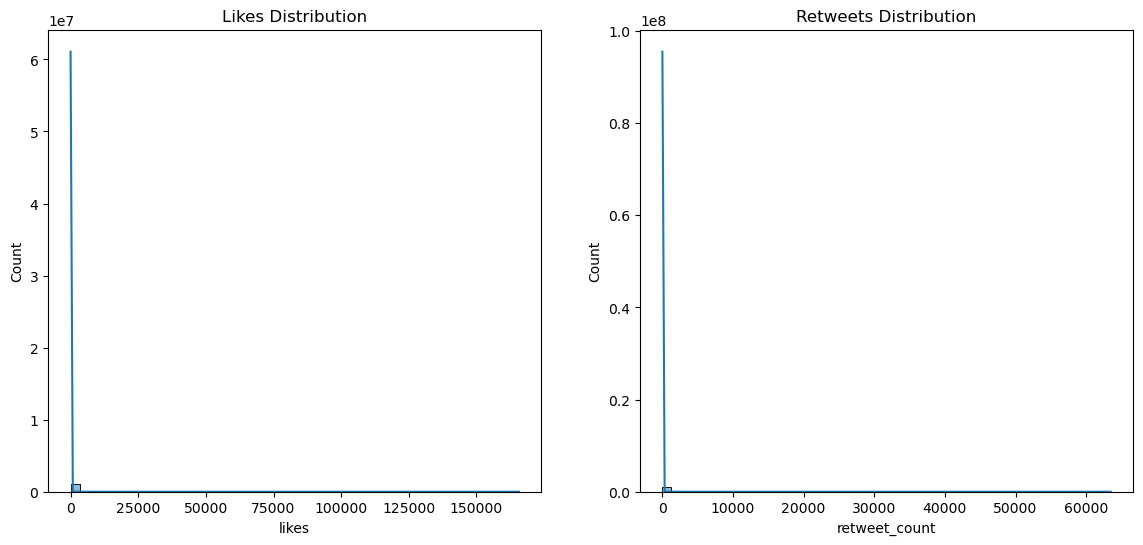

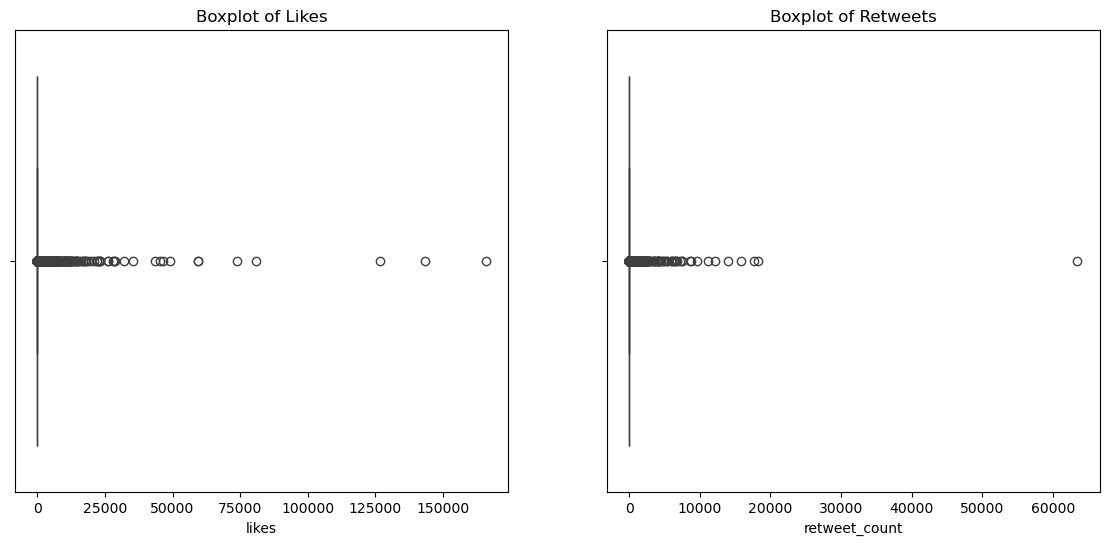

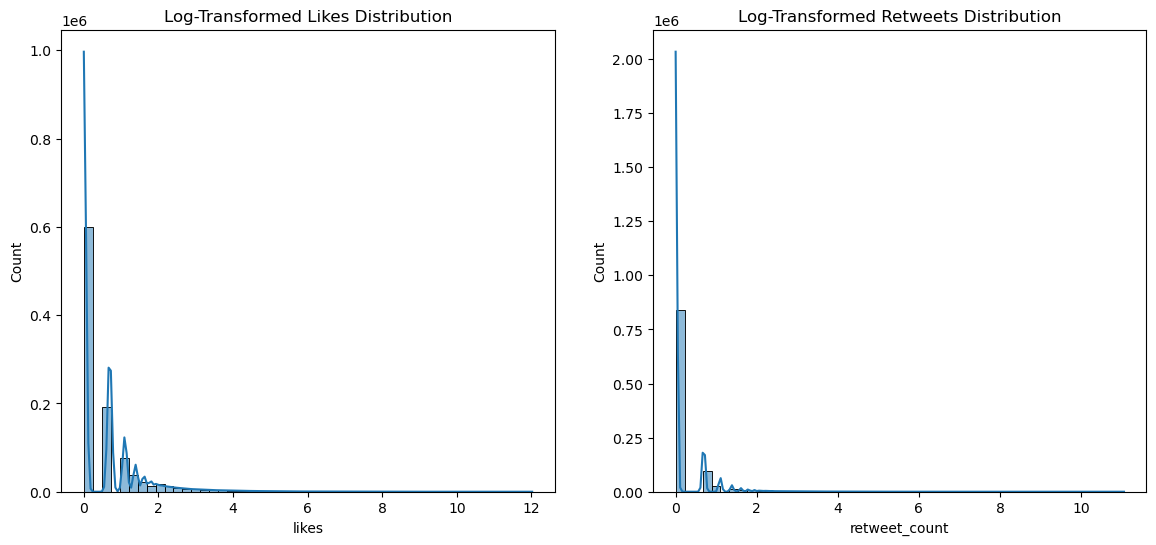

In [177]:
# Subset the data for 'likes' and 'retweets'
likes = twitter_df['likes']
retweets = twitter_df['retweet_count']

# 1. Histogram and KDE for 'likes' and 'retweets'
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(likes, bins=50, kde=True)
plt.title('Likes Distribution')

plt.subplot(1, 2, 2)
sns.histplot(retweets, bins=50, kde=True)
plt.title('Retweets Distribution')

plt.show()

# 2. Boxplot for 'likes' and 'retweets' (helps identify outliers)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=likes)
plt.title('Boxplot of Likes')

plt.subplot(1, 2, 2)
sns.boxplot(x=retweets)
plt.title('Boxplot of Retweets')

plt.show()

# 3. Log-transformed histograms to compress extreme outliers
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(np.log1p(likes), bins=50, kde=True)
plt.title('Log-Transformed Likes Distribution')

plt.subplot(1, 2, 2)
sns.histplot(np.log1p(retweets), bins=50, kde=True)
plt.title('Log-Transformed Retweets Distribution')

plt.show()

In [178]:
# Detect outliers using IQR for 'likes' and 'retweets'

# For 'likes'
Q1_likes = twitter_df['likes'].quantile(0.25)
Q3_likes = twitter_df['likes'].quantile(0.75)
IQR_likes = Q3_likes - Q1_likes

lower_bound_likes = Q1_likes - 3 * IQR_likes
upper_bound_likes = Q3_likes + 3 * IQR_likes

# For 'retweets'
Q1_retweets = twitter_df['retweet_count'].quantile(0.25)
Q3_retweets = twitter_df['retweet_count'].quantile(0.75)
IQR_retweets = Q3_retweets - Q1_retweets

lower_bound_retweets = Q1_retweets - 3 * IQR_retweets
upper_bound_retweets = Q3_retweets + 3 * IQR_retweets

# Identify outliers in 'likes' and 'retweets'
outliers_likes = twitter_df[(twitter_df['likes'] < lower_bound_likes) | (twitter_df['likes'] > upper_bound_likes)]
outliers_retweets = twitter_df[(twitter_df['retweet_count'] < lower_bound_retweets) | (twitter_df['retweet_count'] > upper_bound_retweets)]

print(f"Number of outliers in 'likes' using IQR: {len(outliers_likes)}")
print(f"Number of outliers in 'retweets' using IQR: {len(outliers_retweets)}")


Number of outliers in 'likes' using IQR: 90363
Number of outliers in 'retweets' using IQR: 172679


In [179]:
print(outliers_likes["likes"].describe())
print("\n")
print(outliers_retweets["retweet_count"].describe())

count     90363.000000
mean         77.741609
std        1132.786308
min           5.000000
25%           6.000000
50%          10.000000
75%          26.000000
max      165702.000000
Name: likes, dtype: float64


count    172679.000000
mean          9.995749
std         200.923092
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max       63473.000000
Name: retweet_count, dtype: float64


Observations:

Likes:
* The number of outliers decreased after using the 3x IQR factor, which means the bound have been tightened and fewer low outliers have been excluded .
* The mean, median, and standard deviation suggest that many of the outliers are still relatively small, but there are a few extreme values (as indicated by the high max of 165,702).

Retweets:
* The retweet outliers remain unchanged with the 3x IQR factor, indicating that the distribution of retweets may not be as heavily skewed at the lower end. 
* The presence of very low outliers (min = 1) suggests that many entries are being flagged due to the distribution's natural skew.